### Forecasting
In this task, we explore all the forecasting models from statsmodel, for example, AR, ARMA/ARIMA, SARIMA. The main motivation behind doing this task is to understand how to  model the timeseries data with these algorithms. 

In this work, I have used the dataset 'airplane passenger' to all agorithms. And, figure out which one algorithm is suitable for which data types.

In additon, this notebook gives how to apply the stationarity check with augmented Dickey-Fuller Test. And, first change the non-stationary data into stationary and model with ARMA or can be applied directly ARIMA model with non-stationary dataset.

In [500]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams #set figure size

from pmdarima import auto_arima # for finding arima orders

# for metric
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error,mean_absolute_error

from statsmodels.tsa.stattools import adfuller # for stationarity test
from statsmodels.tsa.statespace.tools import diff 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot,quarter_plot #plots

#for creating models
from statsmodels.tsa.ar_model import AR 
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [203]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [247]:
#load dataset
df= pd.read_csv('Data/airline_passengers.csv', index_col='Month', parse_dates=True)
df.index.freq = 'MS'# since data is monthly start frequency
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


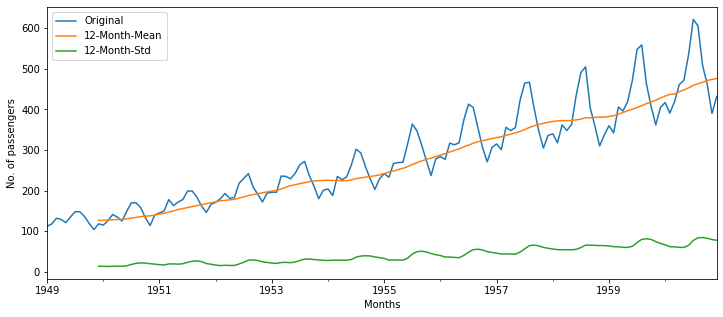

In [196]:
#lets visualize the series
ax = df['Thousands of Passengers'].plot(figsize=(12,5), legend= True, label='Original')
df['Thousands of Passengers'].rolling(window=12).mean().plot(legend= True, label='12-Month-Mean')
df['Thousands of Passengers'].rolling(window=12).std().plot(legend= True, label='12-Month-Std')

ax.autoscale(axis='x',tight=True) # fit to x-axis
ylabel='No. of passengers'
xlabel = 'Months'
ax.set(xlabel=xlabel, ylabel=ylabel) #name axis
plt.show()

From the plot, it is clear that  series  has seasonality with clear upward trend and increase in std over the times

### ETS Decompostion
It is another way to  look whether time series has trend, seasonlaity or not. 

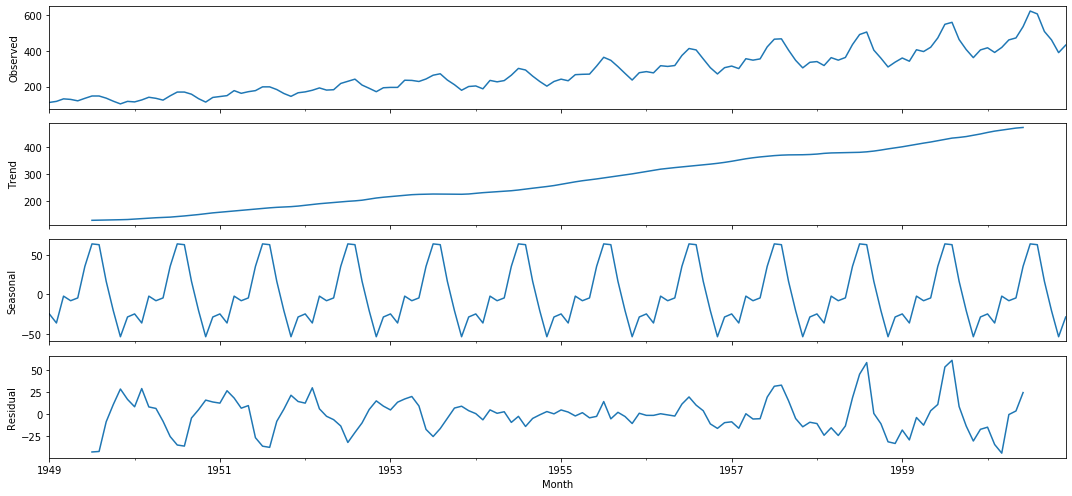

In [174]:
# lets do seasonal decompostion
rcParams['figure.figsize']=15,7 # set figure size
sea_decom = seasonal_decompose(df['Thousands of Passengers'], model='additive')
sea_decom.plot();

Figures show clear trend and some seasonlity

### Auto Correlation Plot
To check whether there is correlation with the shiffted samples in the time series. This Auto Correlation Function (APF) plot is best suite for non-stationary data.

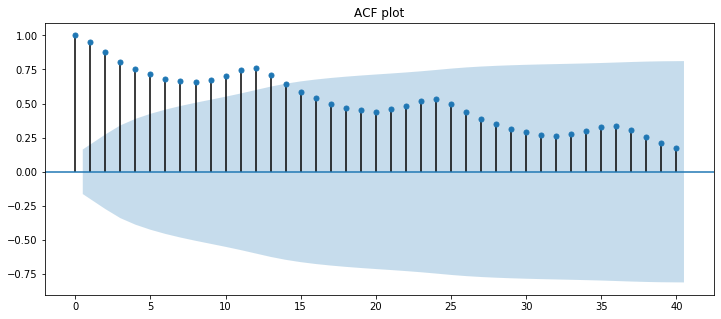

In [201]:
#create auto correaltion plot
plot_acf(df['Thousands of Passengers'], lags=40, title='ACF plot')
plt.show()

The figure cleary shows there is correlation as well as  seasonality  in the time sereies

###  Seasonality and quaterly plot 
lets figure out, which months and qauterly have low and high passenger.

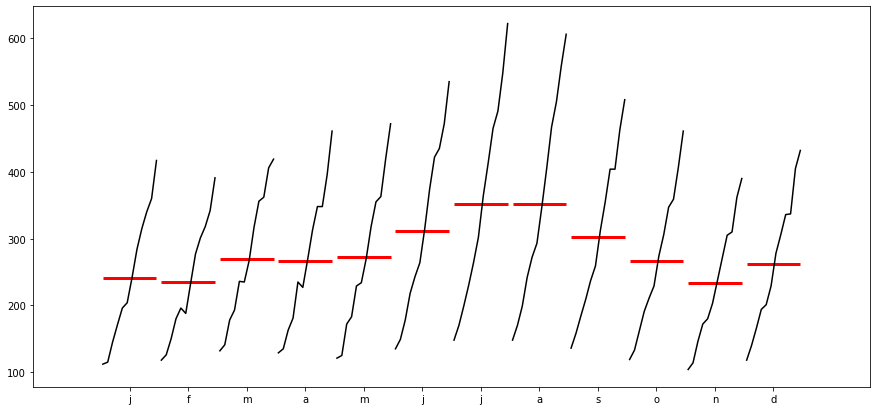

In [177]:
#monthly plot
month_plot(df['Thousands of Passengers']);


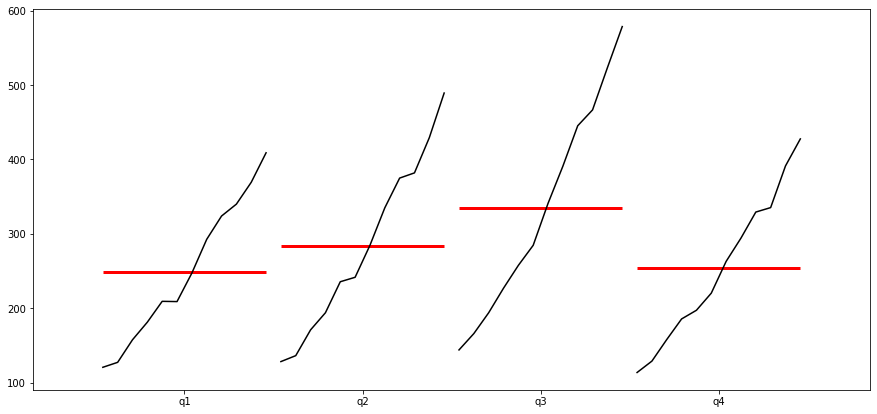

In [168]:
#quaterly plot
quarter_plot(df['Thousands of Passengers'].resample(rule='Q').mean());

From both quaterly and montly plots, we can see there is some up and down in the airplane passenger.
For the month of JUNE and JULY there is high peak as same as in  3rd quater.

### Stationarized Time Series
We have to stationarize the time series data. From the above figures, it is clear seen that there is seasonlity and trend in series. But lets do statistic to proof that the series is non-stationary(showing seasonality and trend).

For this, the augmented Dickey-Fuller Test is used. It tests the hypothesises. Here, the null hyothesis is 'non-stationary'.


In [285]:
def adfuller_test(time_series):
    """
     time_series= time series data
     returns an ADF report
     
    """
    
    # create adfuller  report
    result = adfuller(time_series, autolag='AIC') 
    
    
    #assigin the each value with name and store as pands series
    labels = ['ADF_test','p-value','lags used','observations']
    out = pd.Series(result[0:4],index=labels) #create series

    for key,val in result[4].items(): # add items(critical values) 
        out[f'critical value ({key})']=val
        
   
    #print out
    print(out)
    
   #check hypothesis 
    if np.round(result[1], 2) <= 0.05:
        print("Strong evidence against  to reject  null hypothesis")
        print("It is stationary")
    else:
        print("Weak evidence against  to reject null hypothesis")
        print("It is non-stationary")

In [286]:
#check stationary 
adfuller_test(df['Thousands of Passengers'])

ADF_test                  0.815369
p-value                   0.991880
lags used                13.000000
observations            130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
dtype: float64
Weak evidence against  to reject null hypothesis
It is non-stationary


It tells that this time series data is non-stationary. So, we have to do differencing to make it stationary.

### Models
Lets build the models from  different alogrithms, like AR, ARMA/ARIMA, SARIMA.

Note: we know clearly that this dataset is non-stationary(showing trend or seasonality), which is not suitable to model with AR,  ARMA/ARIMA. But also lets try how it do in prediction.

In [399]:
'''
Note: this is just to understand for myself at what differencing the series become stationary
'''

# return stationary data with 95% confidence level(0.05 significance level)
def return_stationary_series(series, k=2):
    '''
    series = time series data
    k = differecing time 
    return  stationary time seres data
    '''
    for d in range(1, k):
        df_stat = diff(df['Thousands of Passengers'], k_diff = d) # differencing data

        # check p-value
        if np.round(adfuller(df_stat)[1]) <= 0.05:  # round with 2 decimal values
            print(f'Now the time-series is stationary at {d} difference')
            return df_stat
            break
        



Now the time-series is stationary at 1 difference


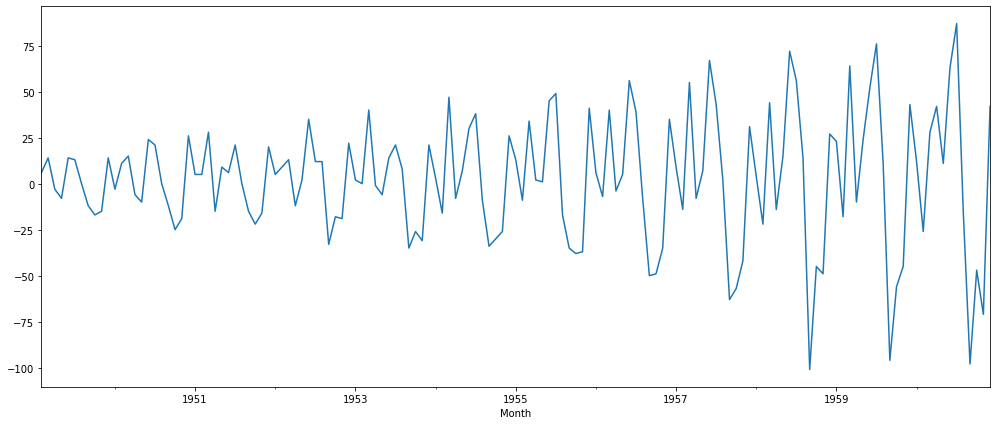

In [400]:
#return stationary series and plot
stationary_series =return_stationary_series(df['Thousands of Passengers'], 10)
stationary_series.plot(figsize=(17,7));

Now, the series looks as stationary. We can test with calling the function adfuller_test().

In [401]:
# testing for stationary
adfuller_test(stationary_series)

ADF_test                 -2.829267
p-value                   0.054213
lags used                12.000000
observations            130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
dtype: float64
Strong evidence against  to reject  null hypothesis
It is stationary


###  Train_Test split

In [488]:
#convert to dataframe
stat_data = stationary_series.to_frame() 

#split test(36 months) and train(remaining months)
train_data_stationary = stat_data.iloc[:108] 
test_data_stationary = stat_data.iloc[108:] 

#original data(non-stationary)
train_data= df.iloc[:108]
test_data= df.iloc[108:] 
 

### Autoregression(AR) Model
In this autoregression model, the linear combination of past values of the variable are happened. It is run against a set of lagged values of order  𝑝 .

In [461]:
# build AR model
model_ar = AR(train_data_stationary) # use stationary data
best_lag = model_ar.select_order(maxlag= 10, ic='aic') # select best maxlag
print(f'best lag: {best_lag}')

# fit model with best maxlag
model_ar_fit = model_ar.fit(maxlag= best_lag) 

#predict
ar_prediction = model_ar_fit.predict(start= test_data_stationary.index[0], 
                                     end= test_data_stationary.index[-1], 
                                     dynamic=False)
ar_prediction.head()

best lag: 9


1958-02-01    -1.412091
1958-03-01     7.414055
1958-04-01    12.770302
1958-05-01    51.016689
1958-06-01    53.701610
Freq: MS, dtype: float64

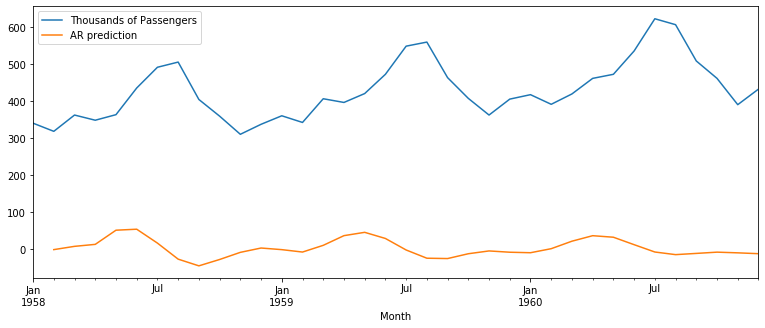

In [462]:
# create plot with test and predicted
test_data.plot(legend= True, label= 'test data')
ar_prediction.plot(legend= True, label='AR prediction', figsize=(13,5))
plt.show()

### Evaluate the Model

In [493]:
result = mean_absolute_error(test_data['Thousands of Passengers'].iloc[1:], ar_prediction)
print(f'AR Error : {result: .2f}')

AR Error :  428.36


In [494]:
test_data.std()

Thousands of Passengers    79.329152
dtype: float64

#### Note: 
When we compare the dispersion of test data(std)  with predicted values (mean_absolute_error), there is  much difference. So, we can say that  AR is too simple model for this dataset and it doesn't address the seasonality in the series.
    

### Forecasting

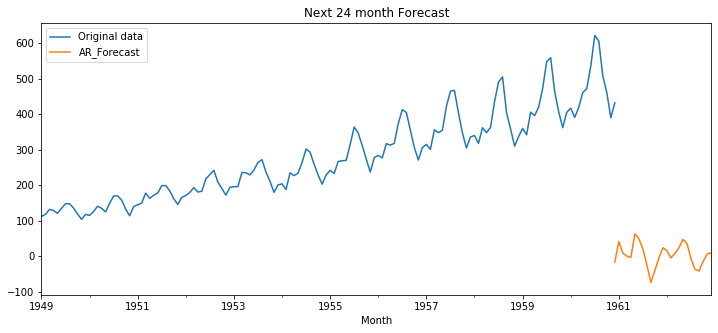

In [485]:
# train with whole dataset(stationary)
ar_final_model = AR(stat_data['Thousands of Passengers']).fit(maxlag= 9, ic='aic')


#forecast next 24
ar_forecast = ar_final_model.predict(start= stat_data.index[-1], 
                                      end=stat_data.index[-1]+24, 
                                      dynamic=False)
#create plots
ax=  df['Thousands of Passengers'].plot(legend= True, label='Original data', title='Next 24 month Forecast')
ar_forecast.plot(legend= True, label='AR_Forecast')
ax.legend(loc=2);

From the figure above, it shows that AR model is not suitable one when there is seasonal in the series.

### Autoregression Moving Averages(ARMA) model
It is the combinatin of AR and MA. AR is the linear combination of lagged values of order 'P' and MA uses the past forecast errors of order 'q' in a regression-like mode .

We can directly fit original series with ARIMA model or can be obtained the same result by making data stationary at first and pass it with the model ARMA. We have already changed into stationary data. So. lets use that data  with ARMA.

In [438]:
#tune parameter  for ARMA
auto_arima(stat_data, seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:                     ARMA(2, 4)   Log Likelihood                -661.292
Method:                       css-mle   S.D. of innovations             23.715
Date:                Fri, 15 Nov 2019   AIC                           1338.585
Time:                        16:45:10   BIC                           1362.288
Sample:                             0   HQIC                          1348.216
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6854      0.134     19.979      0.000       2.422       2.949
ar.L1.y        0.9142      0.082     11.131      0.000       0.753       1.075
ar.L2.y       -0.7709      0.080     -9.629      0.000      -0.928      -0.614
ma.L1.y       -0.8356      0.101     -8.265      0.000      -1.034      -0.637
ma.L2.y        0.3271      0.122      2.691      0.008       0.089       0.565
ma.L3.y        0.3086      0.114      2.699      0.008       0.085       0.533
ma.L4.y       -0.8000      0.079    -10.112      0.000      -0.955      -0.645
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5929           -0.9724j            1.1389           -0.1628
AR.2            0.5929           +0.9724j            1.1389            0.1628
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2            0.3178           -0.9481j            1.0000           -0.1985
MA.3            0.3178           +0.9481j            1.0000            0.1985
MA.4           -1.2500           -0.0000j            1.2500           -0.5000
-----------------------------------------------------------------------------
"""

It suggests ARMA(2, 4) model

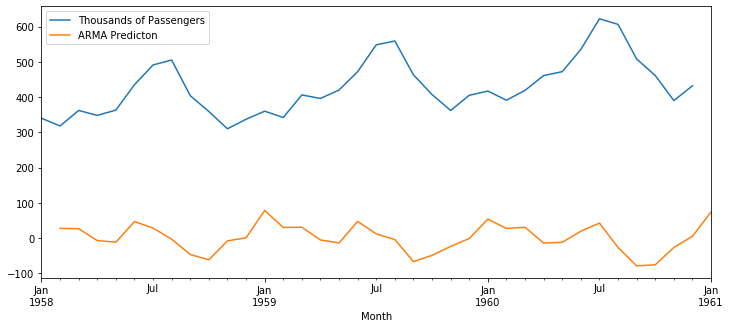

In [486]:
#fit model 
arma_model = ARMA(stat_data, order=(2,4)).fit()

#predict test data
arma_prediction = arma_model.predict(start= len(train_data), 
                                     end= len(train_data)+len(test_data)-1, #  since we differencing with 1
                                     dynamic=False)


#create plots between test and prediction
test_data.plot(legend=True, label = 'Test Data') # testdata plot
arma_prediction.plot(legend=True, label = 'ARMA Predicton')
plt.show()

Looks very bad prediction with this model in this dataset.

#### Evaluate model

In [471]:
arma_result = mean_absolute_error(test_data['Thousands of Passengers'], arma_prediction)
arma_result

427.0453033032634

In [472]:
test_data.std()

Thousands of Passengers    79.329152
dtype: float64

It tells that model doesn't predict the test data very well. And, it is true also since we have 
dataset having seasonality.

### Future Forcast

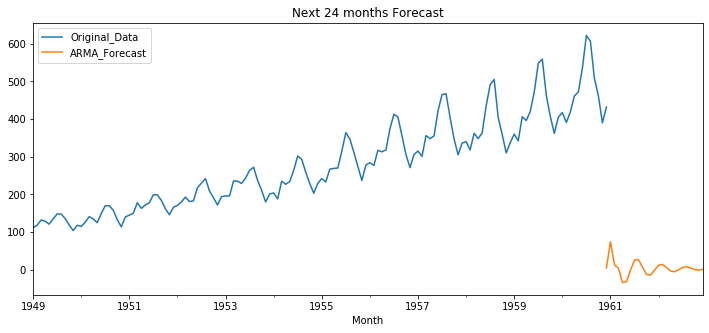

In [475]:
# train with whole dataset(stationary)
arma_model = ARMA(stat_data, order=(2,4)).fit()


#forecast next 24
arma_forecast = arma_model.predict(start=stat_data.index[-1], 
                                      end=stat_data.index[-1]+24, 
                                      dynamic=False)

#create plots
ax=  df['Thousands of Passengers'].plot(legend= True, label='Original_Data', title='Next 24 months Forecast')
arma_forecast.plot(legend= True, label='ARMA_Forecast')
ax.legend(loc=2);


### Autoregression Integration Moving Average(ARIMA)
This model combines AR, I and MA.  AR = Autoregression, I = Integration and MA = Moving Average. This model directly converts the non-stationary series to stationary.
This is equavalent to ARMA(p,q) after differencing the original series with d in  ARIMA(p,d,q).



In [476]:
#tune  parameter for ARIMA
auto_arima(df['Thousands of Passengers'], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  143
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -661.292
Method:                       css-mle   S.D. of innovations             23.715
Date:                Fri, 15 Nov 2019   AIC                           1338.585
Time:                        17:12:15   BIC                           1362.288
Sample:                             1   HQIC                          1348.216
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6854      0.134     19.979      0.000       2.422       2.949
ar.L1.D.y      0.9142      0.082     11.131      0.000       0.753       1.075
ar.L2.D.y     -0.7709      0.080     -9.629      0.000      -0.928      -0.614
ma.L1.D.y     -0.8356      0.101     -8.265      0.000      -1.034      -0.637
ma.L2.D.y      0.3271      0.122      2.691      0.008       0.089       0.565
ma.L3.D.y      0.3086      0.114      2.699      0.008       0.085       0.533
ma.L4.D.y     -0.8000      0.079    -10.112      0.000      -0.955      -0.645
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5929           -0.9724j            1.1389           -0.1628
AR.2            0.5929           +0.9724j            1.1389            0.1628
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2            0.3178           -0.9481j            1.0000           -0.1985
MA.3            0.3178           +0.9481j            1.0000            0.1985
MA.4           -1.2500           -0.0000j            1.2500           -0.5000
-----------------------------------------------------------------------------
"""

Note: ARIMA is same as ARMA with the stationary data.

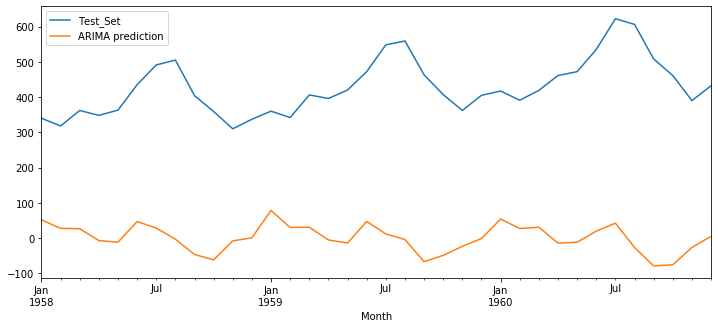

In [477]:
#build model
arima_mode = ARIMA(df['Thousands of Passengers'], order=(2,1,4)).fit()

#forecast next 24
arima_prediction = arima_mode.predict(start=len(train_data), 
                                   end=len(train_data)+len(test_data)-1, 
                                     dynamic=False)

#create plots with test_data and prediction
test_data['Thousands of Passengers'].plot(legend=True, label='Test_Set')
arima_prediction.plot(legend=True, label='ARIMA prediction')
plt.show()


looks bad prediction for the test data with ARIMA model since this model doesn't address seasonality 


### Seasonal Autoregressive Integrated Moving Averages (SARIMA(p,d,q)(P,D,Q)m)
This model addresses the seasonality of series. It has additional paramerter (P,D,Q)m, where P,D,Q represent the seasonal regression, differencing and moving average coefficients respectively and  'm' represents the number of data points (rows) in each seasonal cycle.

In [479]:
#tune  parameter for SARIMAX
auto_arima(df['Thousands of Passengers'], seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -666.022
Date:                Fri, 15 Nov 2019   AIC                           1344.044
Time:                        17:14:10   BIC                           1361.821
Sample:                             0   HQIC                          1351.268
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6619      0.193      3.425      0.001       0.283       1.041
ar.L1          1.6479      0.028     58.889      0.000       1.593       1.703
ar.L2         -0.9096      0.025    -36.755      0.000      -0.958      -0.861
ma.L1         -1.9079      0.355     -5.371      0.000      -2.604      -1.212
ma.L2          0.9977      0.371      2.689      0.007       0.270       1.725
sigma2       611.7553    246.970      2.477      0.013     127.704    1095.807
===================================================================================
Ljung-Box (Q):                      358.18   Jarque-Bera (JB):                 2.78
Prob(Q):                              0.00   Prob(JB):                         0.25
Heteroskedasticity (H):               7.02   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Build SARIMAX Model

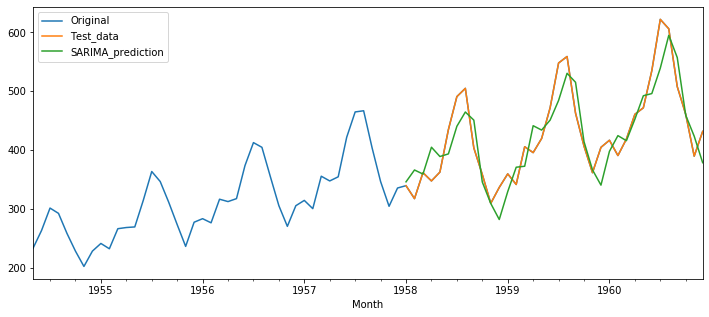

In [497]:
# use the sugessted parameters
sarima_mode = SARIMAX(df['Thousands of Passengers'], order=(2, 1, 2)).fit()

#forecast next 24
sarima_prediction = sarima_mode.predict(start=len(train_data), 
                                      end=len(train_data)+len(test_data)-1, 
                                      dynamic=False)

#create plots
ax= df['Thousands of Passengers'].iloc[-80:].plot(legend= True, label='Original')
test_data['Thousands of Passengers'].plot(legend= True, label='Test_data')
sarima_prediction.plot(legend= True, label='SARIMA_prediction')
ax.legend(loc=2);

#### Model Evaluate

In [502]:
#mean_absolute
absmean = mean_absolute_error(test_data['Thousands of Passengers'], sarima_prediction)
absmean

31.545468954422674

In [504]:
# root mean error
sarima_result = rmse(test_data['Thousands of Passengers'], sarima_prediction)
sarima_result

37.917554885638296

In [503]:
# test data std
test_data.std()

Thousands of Passengers    79.329152
dtype: float64

#### Note: 
we can see that SARIMA model gives better result than ARIMA since SARIMA model address seasonlity, but lack in ARIMA model.

### Forcast with SARIMA model

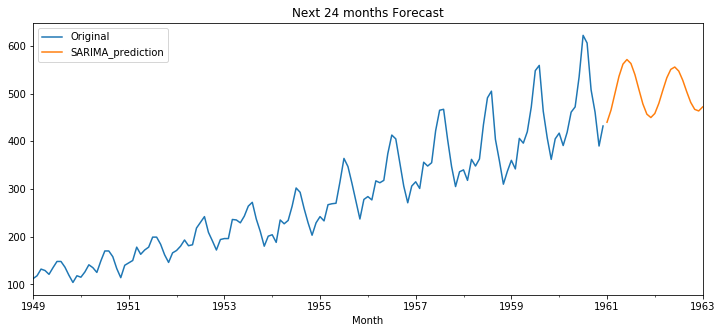

In [482]:
# train with whole dataset
sarima_model = SARIMAX(df['Thousands of Passengers'], order=(2, 1, 2)).fit()


#forecast next 24 months
sarima_prediction = sarima_model.predict(start=len(df), 
                                      end=len(df)+24, 
                                      dynamic=False)

#create plots
ax=  df['Thousands of Passengers'].plot(title= 'Next 24 months Forecast',legend= True, label='Original')
sarima_prediction.plot(legend= True, label='SARIMA_prediction')
ax.legend(loc=2)
plt.show()

#### Conclusion:
When we comapare these three models(AR, ARMA/ARIMA, SARIMA), the result get better from AR to ARMA/ARIMA to SARIMA. SARIMA did very well since it can address the seasonality in the series dataset. Rest Models are to simple to learn pattern the series.

I have also tried this dataset with Holt-Winter method which did very good result with additive trend(mean_absolute_error = 25.8, bit lesser than SARIMA result). You can find the Holt-Winter method result in the another jupyter notebook 'Time-Series-Analysis (Statsmodels).ipynb'